In [1]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model

# Define paths
models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [6]:
# ANNEAL_T_START = 5.0
# ANNEAL_STEPS = 100
# ANNEAL_FALLOFF = 0.4
# T_END = 1.0
# model_dtype = torch.float32

ONLY_LAST = True

# glob_filenames = glob(str(models_dir / "hyprbm_tfim_4x4_20000_suscept_seed*_20260120_*.pt"))
# glob_filenames = glob(str(models_dir / "hyprbm_tfim_4x4_20000_suscept_seed*_20260121_*.pt"))
glob_filenames = glob(str(models_dir / "hyprbm_tfim_4x4_20000_suscept_seed*_20260122_*.pt"))
print(f"Found {len(glob_filenames)} model files.")
def estimate_susceptibility(model, h_val, n_samples, k_steps, rng):
    dtype = next(model.parameters()).dtype

    with torch.no_grad():
        cond_batch_gen = torch.full((n_samples, 1), h_val, device=device, dtype=dtype)

        schedule_tensor = torch.tensor([1.0] * k_steps, device=device, dtype=dtype)
        # t_indices = torch.arange(k_steps, device=device, dtype=model_dtype)
        # center = k_steps / 2.0
        # s = 1.0 / (1.0 + torch.exp(ANNEAL_FALLOFF * (t_indices - center)))
        # schedule_tensor = T_END + (ANNEAL_T_START - T_END) * s
        samples = model.generate(cond_batch_gen, T_schedule=schedule_tensor, rng=rng, only_last=ONLY_LAST) # shape (n_samples, n_visible)

    # create a batch of conditioning values for later gradient computation
    # cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)
    if ONLY_LAST:
        # samples: (n_samples, n_visible)
        cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)
    else:
        # samples: (num_steps, n_samples, n_visible)
        num_steps = samples.shape[0] # post_burnin steps
        samples = samples.reshape(-1, samples.shape[-1])  # (num_steps * n_samples, n_visible)
        cond_batch_grad = torch.full((samples.shape[0], 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # we evaluate log_score with gradients enabled on cond_batch
    log_psi = model.log_score(samples, cond_batch_grad)

    # since we parametrized log_psi with cond_batch the Jacobian has only main diagonal terms
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch_grad,
        grad_outputs=torch.ones_like(log_psi), # upstream gradient in VJP (scales each main diag term)
        create_graph=False
    )[0]

    # quadratic formula can be simplified to variance of the gradient (Var(d log_psi / dh))
    chi = torch.var(grads.squeeze(), unbiased=True)
    return chi.item()


Found 20 model files.


In [ ]:
# Parallel evaluation over seeds using joblib
from joblib import Parallel, delayed

def eval_model(model_path_str):
    import math, datetime, re
    from pathlib import Path
    import numpy as np
    import pandas as pd
    import torch
    from hyper_rbm import load_model

    device = "cpu"
    model_path = Path(model_path_str)
    model, config = load_model(model_path, device)
    h_support = config.get("h_support", [])
    seed = config.get("seed", None)
    if seed is None:
        m = re.search(r'seed(\d+)', model_path.name)
        seed = int(m.group(1)) if m else -1
    SIDE_LENGTH = int(math.sqrt(model.num_v))
    ref_file = Path("tfim_4x4_suscept_ref.csv")
    ref_df = pd.read_csv(ref_file)
    H_MIN = 0.5
    H_MAX = 4.5
    SWEEP_POINTS = 50
    SAMPLES_EVAL = 3000
    K_STEPS_EVAL = 15
    h_eval = np.linspace(H_MIN, H_MAX, SWEEP_POINTS)
    chi_values = []
    for i, h in enumerate(h_eval):
        rng_point = torch.Generator(device=device).manual_seed(seed)
        chi = estimate_susceptibility(model, h, n_samples=SAMPLES_EVAL, k_steps=K_STEPS_EVAL, rng=rng_point)
        chi_values.append(chi)
    # Save per-seed result
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    results = np.column_stack((h_eval, chi_values))
    file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_rbm_seed{seed}_{timestamp}.csv"
    save_path = Path("results") / file_name
    header = "h,chi_F"
    np.savetxt(save_path, results, delimiter=",", header=header, comments="")
    return {"seed": seed, "h_eval": h_eval, "chi_values": np.array(chi_values)}


In [16]:

# Evaluate all checkpoints in parallel
all_results = Parallel(n_jobs=-1)(delayed(eval_model)(model_path_str) for model_path_str in glob_filenames)


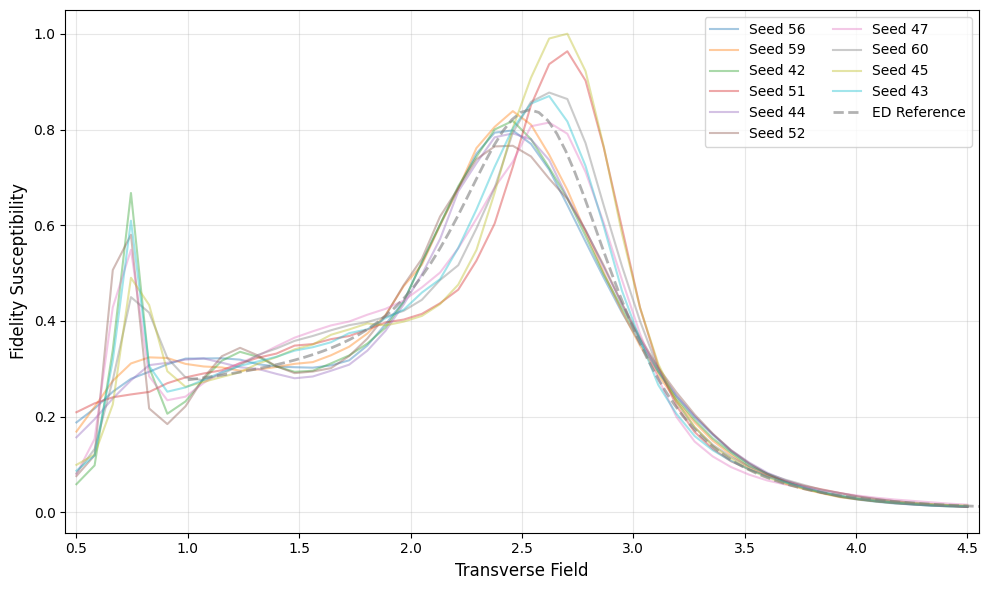

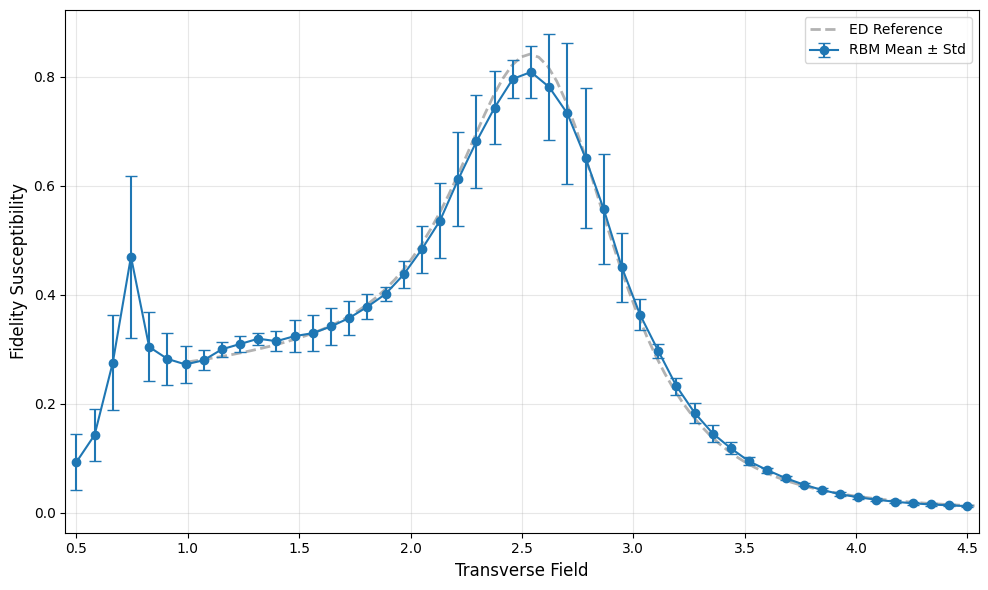

In [17]:
import scipy

# --- Plot all seeds individually ---
plt.figure(figsize=(10, 6), dpi=100)
ref_df = pd.read_csv("tfim_4x4_suscept_ref.csv")
for result in all_results[:10]:
    plt.plot(result["h_eval"], result["chi_values"], '-', alpha=0.4, label=f"Seed {result['seed']}")
plt.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray", linewidth=2, alpha=0.6, label="ED Reference")
plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0.50 - 0.05, 4.5 + 0.05)
plt.legend(loc="upper right", fontsize=10, ncol=2)
plt.tight_layout()
plt.show()

# --- Plot average with error bars ---
all_chi = np.stack([r["chi_values"] for r in all_results[:10]], axis=0)
# mean_chi = np.mean(all_chi, axis=0)
mean_chi = np.median(all_chi, axis=0)
# std_chi = np.std(all_chi, axis=0)/np.sqrt(all_chi.shape[0])  # standard error of the mean
# error_chi = scipy.stats.sem(all_chi, axis=0)  # standard error of the mean
error_chi = np.std(all_chi, axis=0)  # standard error of the mean
h_eval = all_results[0]["h_eval"] if all_results else np.linspace(1.0, 4.5, 50)
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray", linewidth=2, alpha=0.6, label="ED Reference")
plt.errorbar(h_eval, mean_chi, yerr=error_chi, fmt='o-', color='tab:blue', capsize=4, label="RBM Mean ± Std")
plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0.50 - 0.05, 4.5 + 0.05)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.show()

* 10 seeds
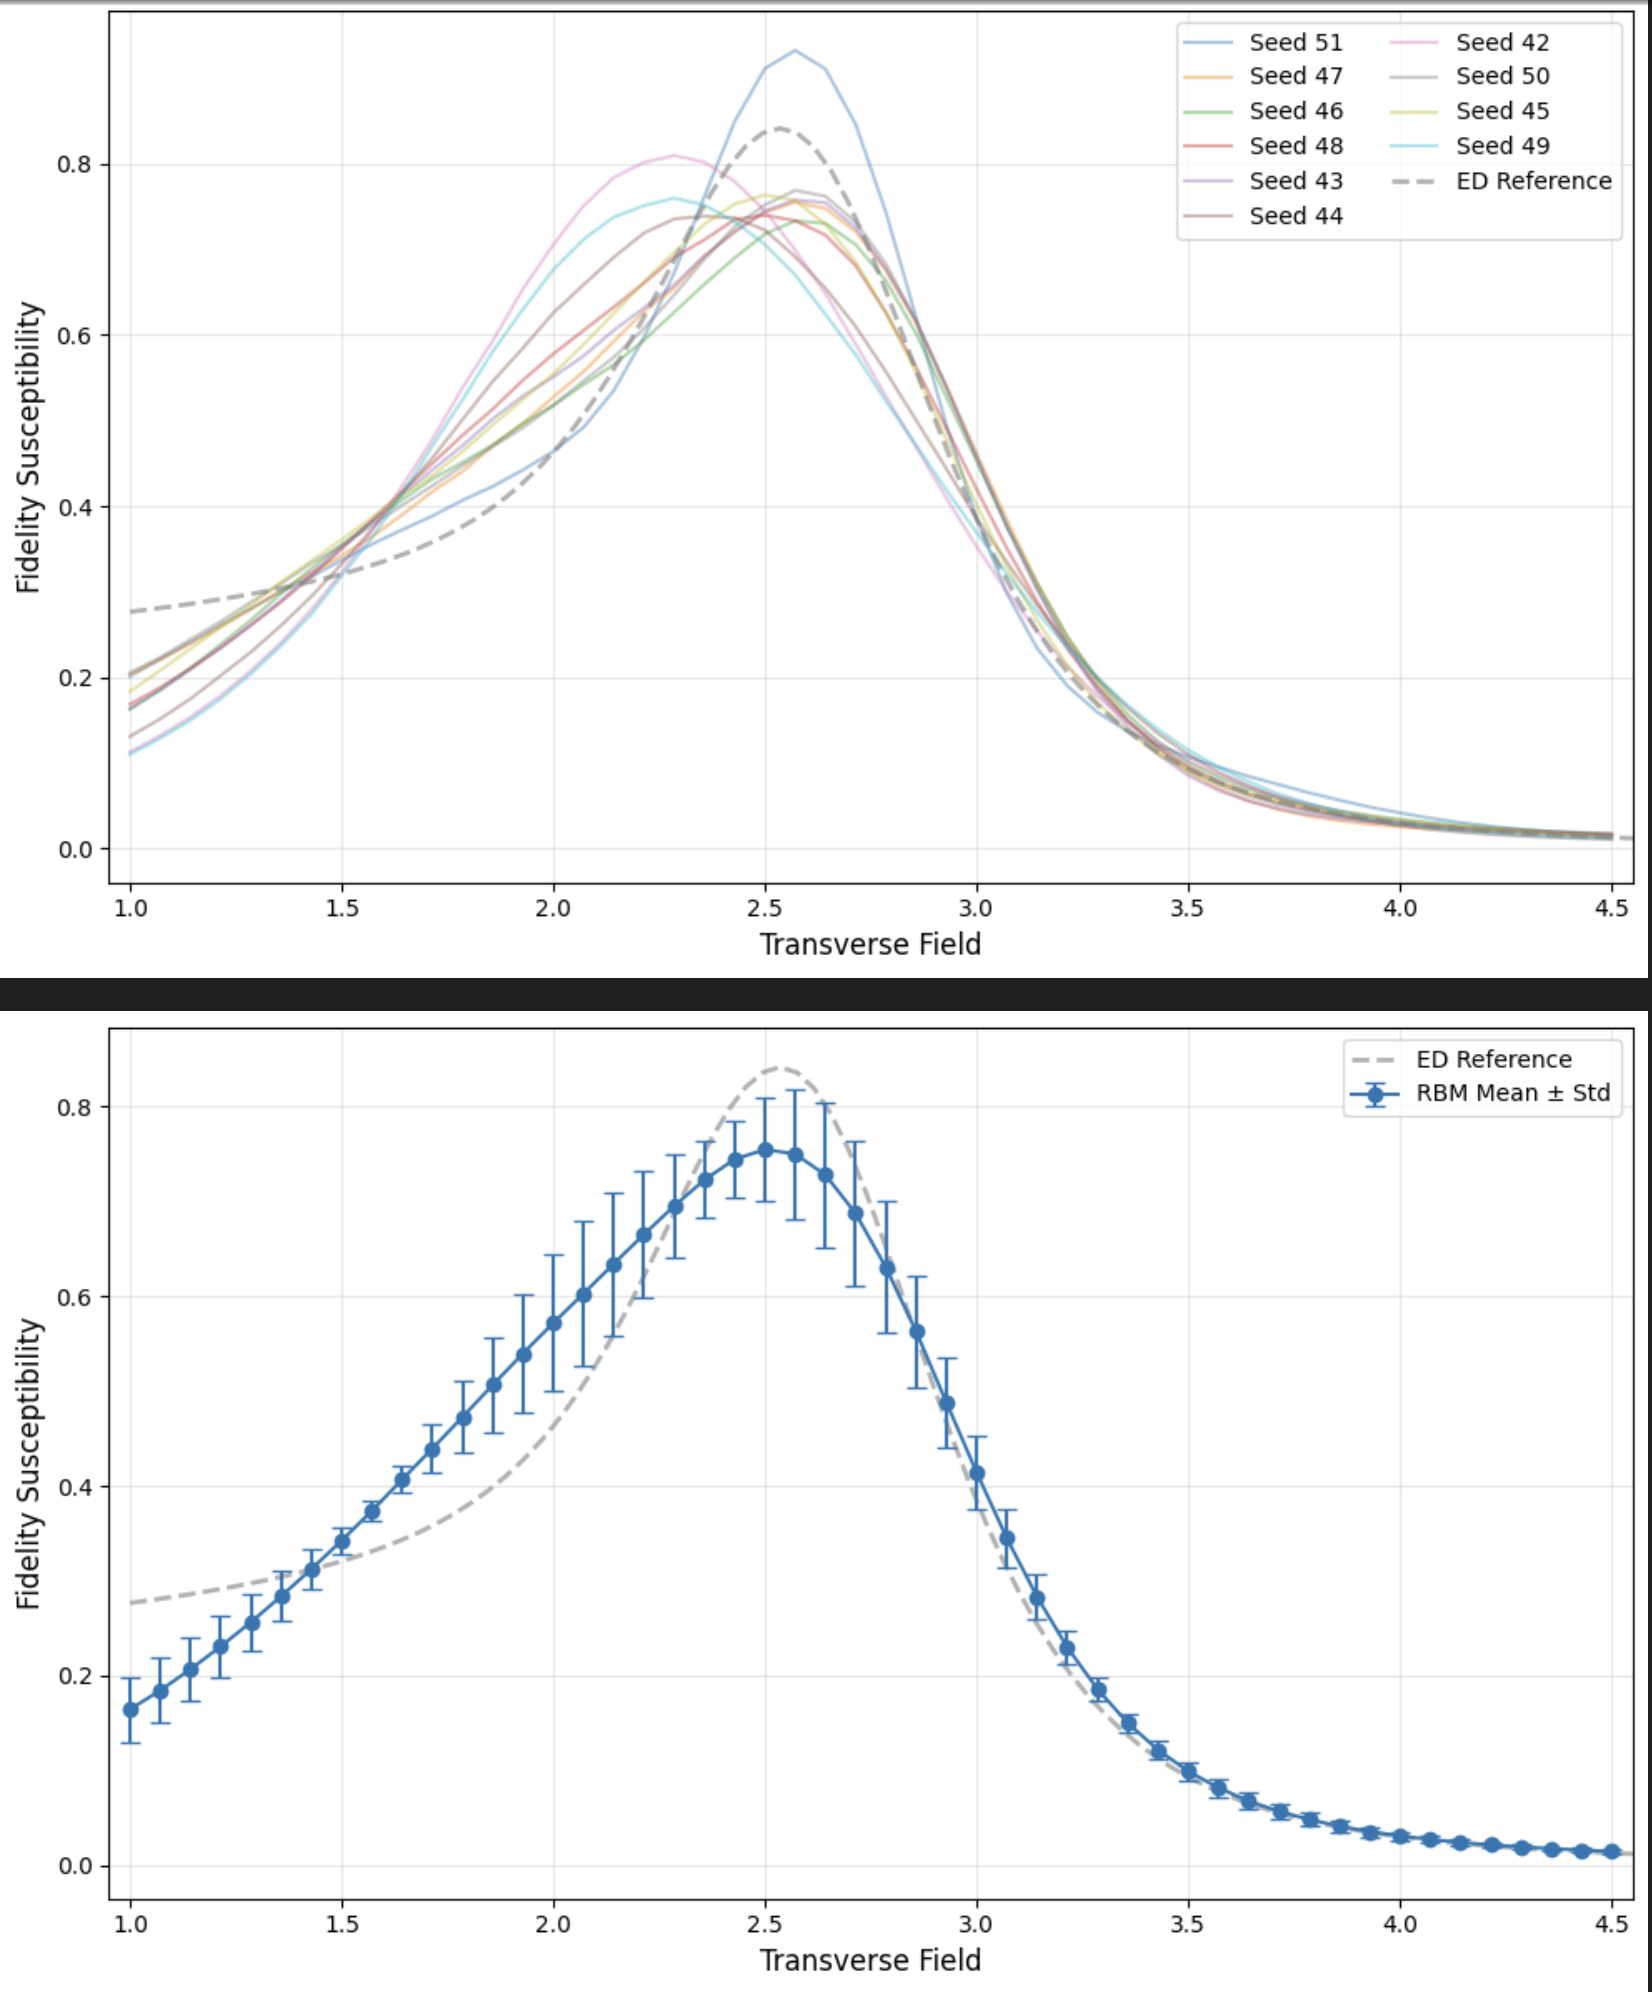

In [12]:
# Example: Load one model and generate a batch of samples
import torch
from hyper_rbm import load_model

# Path to a model checkpoint (pick the first one found)
if len(glob_filenames) == 0:
    raise RuntimeError("No model files found in models_dir.")
model_path = glob_filenames[0]
model_path = Path(model_path)
print(f"Loading model from: {model_path}")

# Load model (on CPU for this example)
model, config = load_model(model_path, device="cpu")

# Set up generation parameters
n_samples = 100  # number of parallel chains (batch size)
k_steps = 20    # number of MC steps
h_val = 2.0     # example field value
rng = torch.Generator(device="cpu").manual_seed(42)

# Conditioning batch
cond_batch = torch.full((n_samples, 1), h_val, device="cpu", dtype=torch.float32)
T_schedule = torch.tensor([1.0] * k_steps, device="cpu", dtype=torch.float32)

# Generate samples (all post-burnin steps)
samples = model.generate(cond_batch, T_schedule=T_schedule, rng=rng, burnin=5, only_last=False)
print(f"Generated samples shape: {samples.shape}")  # (num_steps, n_samples, num_visible)

# Optionally, flatten to treat all as independent samples
flat_samples = samples.view(-1, samples.shape[-1]).unsqueeze(0)
print(f"Flattened samples shape: {flat_samples.shape}")

Loading model from: models/hyprbm_tfim_4x4_20000_suscept_seed42_20260122_024355.pt
Generated samples shape: torch.Size([15, 100, 16])
Flattened samples shape: torch.Size([1, 1500, 16])


In [6]:
# with only last:
samples = model.generate(cond_batch, T_schedule=T_schedule, rng=rng, only_last=True)
print(f"Generated samples shape: {samples.shape}")  # (num_steps, n_samples, num_visible)

Generated samples shape: torch.Size([1, 100, 16])
